### Aplicação de modelos de aprendizado de máquina não supervisionado para base de dados de licitações públicas
### Autor: Eduardo P. Lima

Este notebook apresenta técnicas de aprendizado de máquina em um dataset de licitações públicas realizadas por órgãos
do estado do Rio Grande do Norte. 

O conjunto de dados adquirido possui os seguintes atributos, divididos entre características do órgão realizador dos certames, da licitação realizada e da empresa vencedora:

Atributos do órgão

* natureza_orgao: tipo do órgão que realizou o procedimento licitatório ('ADMINISTRAÇÃO DIRETA MUNICIPAL, ADMINISTRAÇÃO DIRETA ESTADUAL, ADMINISTRAÇÃO INDIRETA ESTADUAL, PODER EXECUTIVO MUNICIPAL > 50.000 HAB, PODER EXECUTIVO MUNICIPAL < 50.000 HAB, PODER LEGISLATIVO/ TCE, PODER LEGISLATIVO MUNICIPAL > 50.000 HAB, PODER LEGISLATIVO MUNICIPAL< 50.000 HAB, ADMINISTRAÇÃO INDIRETA MUNICIPAL E FUNDOS ESPECIAIS VINC. AOS MUNICÍPIOS, PODER JUDICIÁRIO, MINISTÉRIO PÚBLICO , DEFENSORIA PÚBLICA, CONSÓRCIO PÚBLICO)
iloc[0]
       'TOMADA DE PREÇOS', 'SRP - PREGÃO ELETRÔNICO', 'PREGÃO PRESENCIAL',
       'SRP - PREGÃO PRESENCIAL', 'CHAMADA PÚBLICA - OUTROS',
       'SISTEMA DE REGISTRO DE PREÇO', 'PUBLICIDADE - CONCORRÊNCIA',
       'CONVITE', 'CHAMADA PÚBLICA - ALIMENTAÇÃO ESCOLAR',
       'SRP - CONCORRÊNCIA', 'ABERTO', 'PUBLICIDADE - TOMADA DE PREÇOS',
       'FECHADO', 'RDC ELETRÔNICO - ABERTO', 'CONCORRÊNCIA ELETRÔNICA',
       'RDC PRESENCIAL - ABERTO')
* classificacao_objeto: tipo de objeto licitado ('SERVIÇO - OUTROS', 'LOCAÇÃO DE IMÓVEIS', 'OUTRO (ESPECIFICAR)',
       'COMPRA - MATERIAL PERMANENTE', 'COMPRA - MATERIAL DE CONSUMO',
       'OBRA', 'SERVIÇO DE PUBLICIDADE',
       'SERVIÇO DE NATUREZA CONTÍNUA (EXCETO ENGENHARIA)', 'CONCESSÃO',
       'UTILIZAÇÃO DE PROGRAMA DE INFORMÁTICA', 'SERVIÇO DE CONSULTORIA',
       'LOCAÇÃO - OUTROS', 'LOCAÇÃO DE EQUIPAMENTOS',
       'SERVIÇO DE ENGENHARIA', 'CESSÃO DE DIREITOS',
       'AQUISIÇÃO DE BENS IMÓVEIS', 'ALIENAÇÃO DE BENS MÓVEIS',
       'ALIENAÇÃO DE BENS IMÓVEIS',
       'SERVIÇO DE ORGANIZAÇÃO DE CONCURSO PÚBLICO', 'PERMISSÃO')
* ano: ano de realização do procedimento licitatório
* ano_eleicao: se o ano em que o certame foi realizado é eleitoral (apenas 2022 no conjunto analisado)
* semana_publicacao: semana do ano em que foi realizado o certame
* semanas_pagamentos: período em que o vencedor recebeu pagamentos referentes aquele procedimento licitatório, em semanas
* total_orcado: total orçado para a licitação, em reais
* total_pago: total efetivamente pago no curso do contrato resultante da licitação, em reais

Atributos do vencedor:

* total_pagamentos_licitante: total que o licitante vencedor da licitação já recebeu do mesmo ente em todas as licitações que venceu, em reais
* max_pagamento_licitante: maior pagamento já realizado pelo órgão favorecendo o licitante, em reais
* quantidade_licitacoes_licitante: quantidade de procedimentos que o licitante já venceu no mesmo órgão
* qtd_cnaes_licitante: quantas atividades econômicas o licitante registrou para sua empresa
* cnae_principal_licitante: a atividade ecômica principal do licitante
* situacao_cadastral_licitante: situação do cadastro (01 Nula, 02 Ativa, 03 Suspensa, 04 Inapta, 05 Ativa Não Regular, 08 Baixada)
* capital_social_licitante: capital social da empresa
* porte_empresa_licitante: porte da empresa (01	Microempresa, 03 Empresa de Pequeno Porte, 05 Demais)
* natureza_juridica_licitante: natureza do licitante (consultar natureza_juridica.csv)
* socios_licitante: json com sócios da empresa, possível cruzamento com outras bases



#### 1. Configuração do ambiente

In [215]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt

from slugify import slugify

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder

In [216]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [217]:
df = pd.read_excel('dataset.xlsx')

In [218]:
df['ano_eleicao'] = df['ano'].apply(lambda x: 1 if x == 2022 else 0)

In [219]:
len(df.columns)

24

#### 2. Análise exploratória dos dados

Nessa seção visualizamos a distribuição dos dados, checando colunas desbalanceadas e realizando ajustes quando necessário. 

In [220]:
df.head()

,esfera,natureza_orgao,modalidade_licitacao,classificacao_objeto,ano,data_publicacao,semana_publicacao,semanas_pagamentos,total_orcado,total_pago,...,cnae_principal_licitante,data_inicio_licitante,situacao_cadastral_licitante,quantidade_socios_licitante,capital_social_licitante,porte_empresa_licitante,natureza_juridica_licitante,socios_licitante,tempo_abertura_publicacao_licitacao,ano_eleicao
0,M,ADMINISTRAÇÃO DIRETA MUNICIPAL,SRP - RDC,SERVIÇO - OUTROS,2021,2021-09-14,37,140,40000.000,18295.600,...,9411100.000,1968-10-01,2.000,1.000,0.000,5.000,3999.000,"{'codigoPais': '', 'cpfCnpj': '00042292379449'...",19341.000,0
1,E,ADMINISTRAÇÃO DIRETA ESTADUAL,NaN,SERVIÇO - OUTROS,2023,2023-03-14,11,248,1620.000,3596.310,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,M,ADMINISTRAÇÃO DIRETA MUNICIPAL,NaN,LOCAÇÃO DE IMÓVEIS,2023,2023-10-25,43,305,79800.000,625100.000,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,E,ADMINISTRAÇÃO DIRETA ESTADUAL,CREDENCIAMENTO - CHAMAMENTO PÚBLICO,SERVIÇO - OUTROS,2021,2021-03-26,12,90,9875.000,18575.000,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,M,ADMINISTRAÇÃO DIRETA MUNICIPAL,NaN,SERVIÇO - OUTROS,2021,2021-02-02,5,63,5000.000,12575.000,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


#### Atributos do órgão

A natureza dos órgãos que realizaram as licitação descreve sua função constitucional e/ou poder que representa. Vemos no gráfico a seguir que a maioria (53,88% do universo) dos órgãos são prefeituras de pequeno porte (até 50 mil habitantes). 

<Axes: xlabel='natureza_orgao'>

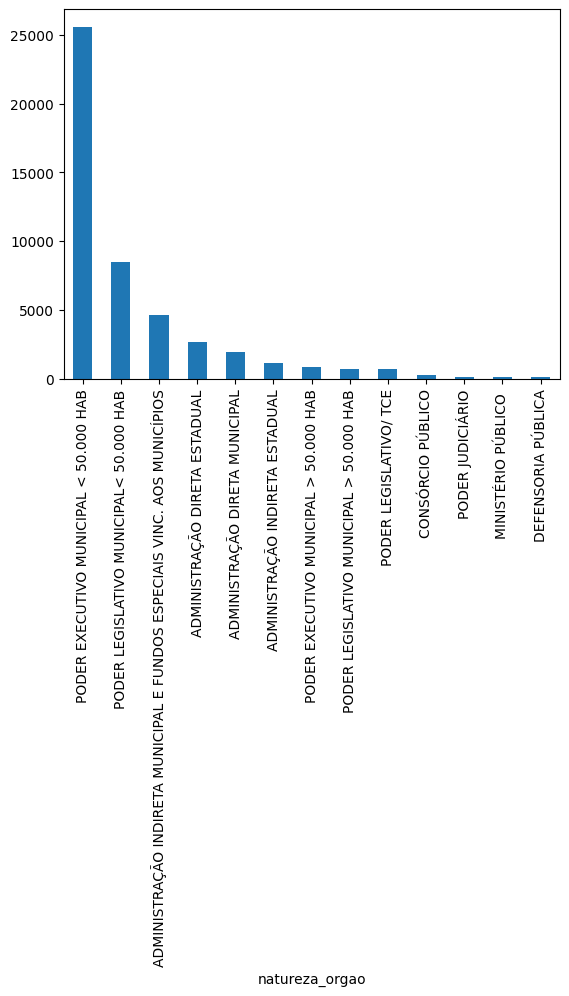

In [221]:
df.natureza_orgao.value_counts().plot(kind='bar')

#### Atributos da licitação

Em relação aos procedimentos licitatórios realizados, vemos uma predominância de pregões eletrônicos para serviços variados. O pregão eletrônico é a modalidade de licitação obrigatória para aquisição de bens e serviços comuns, cujo critério de julgamento poderá ser o de menor preço ou o de maior desconto, conforme o inciso XLI, do Art. 6º da Lei nº 14.133/2021. A categoria mais frequente abrange objetos de diferentes características: aluguel de máquina, manutenção de computadores, fornecimento de energia elétrica etc. Assim sendo, é esperado que seja representada em excesso no conjunto de dados. 

<Axes: xlabel='modalidade_licitacao'>

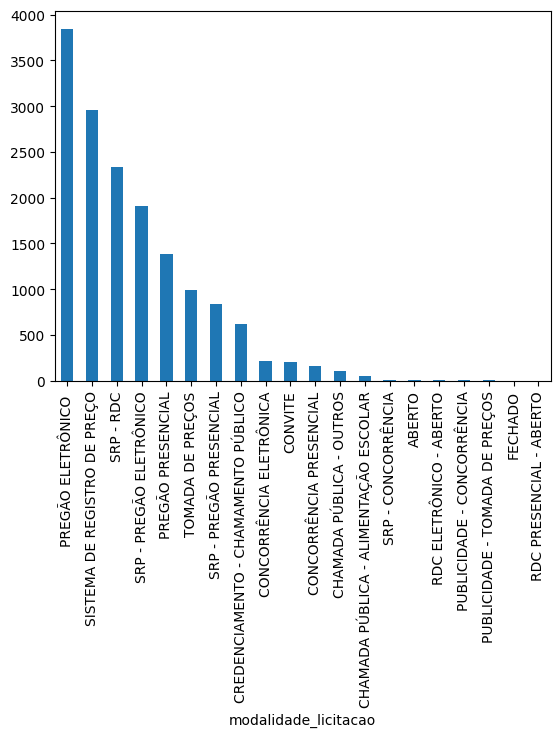

In [222]:
df.modalidade_licitacao.value_counts().plot(kind='bar')

<Axes: xlabel='classificacao_objeto'>

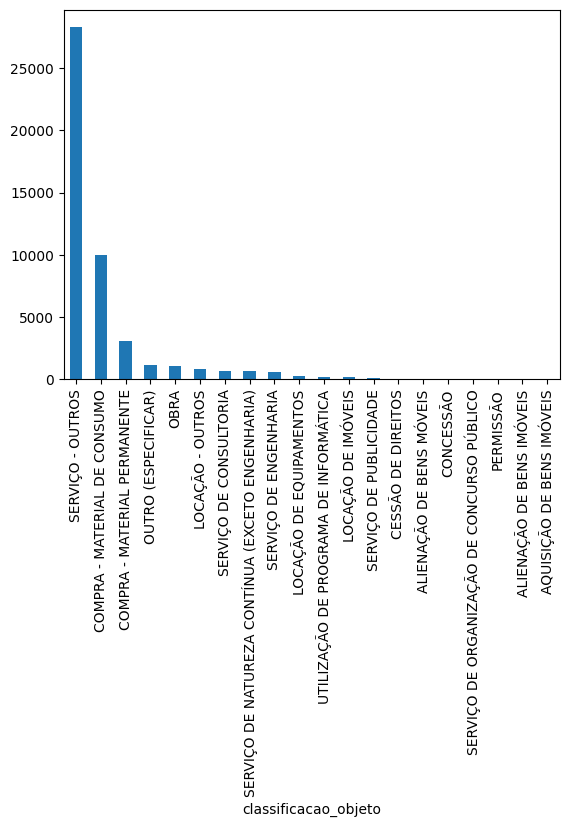

In [223]:
df.classificacao_objeto.value_counts().plot(kind='bar')

Em relação ao período que ocorreu a licitação, vemos que 2023 foi o ano com maior ocorrência de certames. Os procedimentos com maior frequência nas primeiras semanas do ano

<Axes: xlabel='ano'>

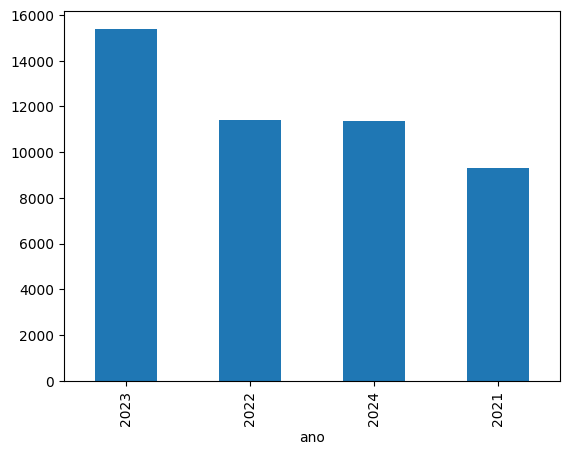

In [224]:
df.ano.value_counts().plot(kind='bar')

<Axes: ylabel='Frequency'>

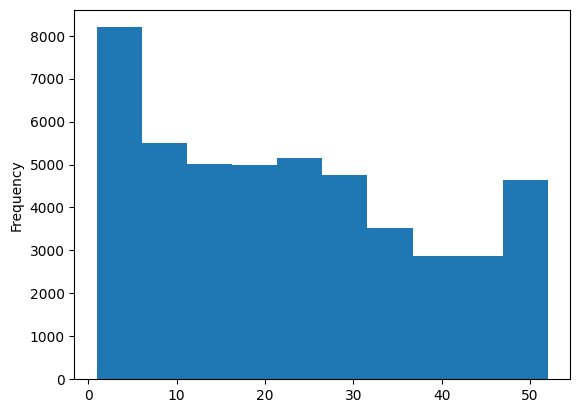

In [225]:
df.semana_publicacao.plot(kind='hist')

Observa-se que a maioria das licitações possuem uma duração de pagamentos de aproximadamente 40 semanas (9 meses).

<Axes: ylabel='Frequency'>

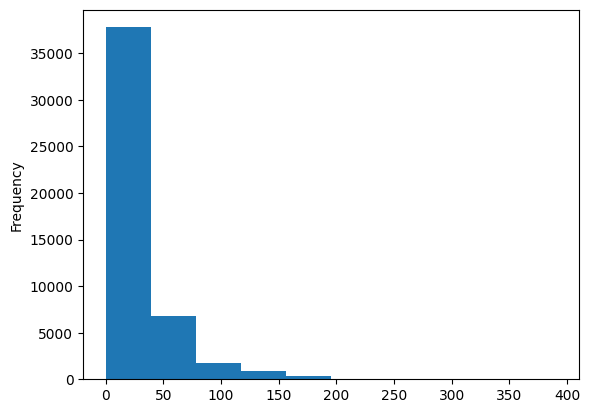

In [226]:
df.semanas_pagamentos.plot(kind='hist')

#### Atributos do licitante

Os atributos `'total_pagamentos_licitante'`, `'quantidade_licitacoes_licitante'` e `'max_pagamento_licitante'` representam, respectivamente, o total de pagamentos recebidos, a quantidade de licitações que uma empresa venceu para o mesmo órgão daquele certame e o maior pagamento feito a um licitante. O gráfico 3d permite visualizar a distribuição dessas variáveis, apresentando os valores mais destoantes do conjuntos. É possível perceber três pontos de dados de interessantes: um licitante que venceu mais de 100 certames no mesmo órgão, outro que recebeu um total de mais de 200 milhões e um terceiro que recebeu em um só pagamento aproximadamente 15 milhões.

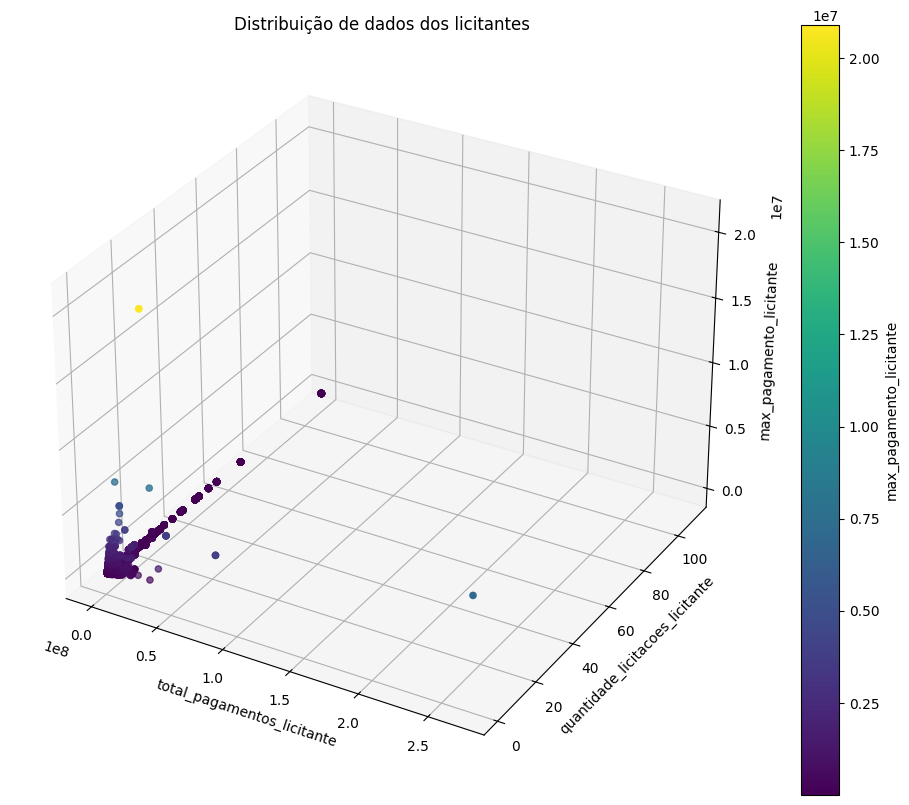

In [227]:
x = df['total_pagamentos_licitante']
y = df['quantidade_licitacoes_licitante']
z = df['max_pagamento_licitante']

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
ax.set_xlabel('total_pagamentos_licitante')
ax.set_ylabel('quantidade_licitacoes_licitante')
ax.set_zlabel('max_pagamento_licitante')

# Adding a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('max_pagamento_licitante')

plt.title('Distribuição de dados dos licitantes')
plt.show()

Em relação à situação cadastral e ao porte das empresas contratadas, a maioria são microempresas em situação ativa. 

<Axes: xlabel='situacao_cadastral_licitante'>

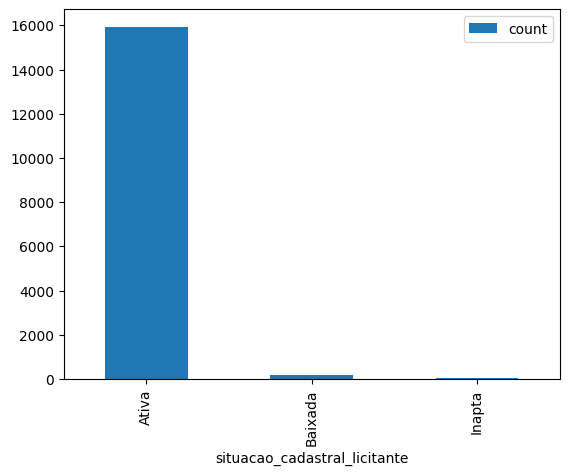

In [228]:
dict_situacao = {1:'Nula', 2:'Ativa', 3:'Suspensa', 4:'Inapta', 5:'Ativa Não Regular', 8:'Baixada'}
df_situacao = df.situacao_cadastral_licitante.value_counts().reset_index()
df_situacao['situacao_cadastral_licitante'] = df_situacao['situacao_cadastral_licitante'].apply(lambda x: dict_situacao[x])
df_situacao.set_index('situacao_cadastral_licitante', inplace=True)
df_situacao.plot(kind='bar')

<Axes: xlabel='porte_empresa_licitante'>

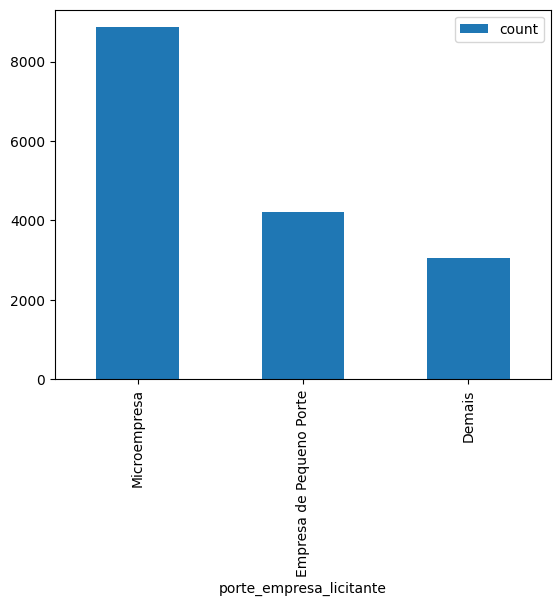

In [229]:
dict_porte = {1:'Microempresa', 3:'Empresa de Pequeno Porte', 5:'Demais'}
df_porte = df.porte_empresa_licitante.value_counts().reset_index()
df_porte['porte_empresa_licitante'] = df_porte['porte_empresa_licitante'].apply(lambda x: dict_porte[x])
df_porte.set_index('porte_empresa_licitante', inplace=True)
df_porte.plot(kind='bar')

In [230]:
df_natureza_juridica = pd.read_csv('natureza_juridica.csv', on_bad_lines='skip', sep=';')
df_natureza_juridica = df.natureza_juridica_licitante.value_counts().reset_index().merge(df_natureza_juridica, left_on='natureza_juridica_licitante', right_on='Código').drop(columns=['Código'])

<Axes: xlabel='Descrição'>

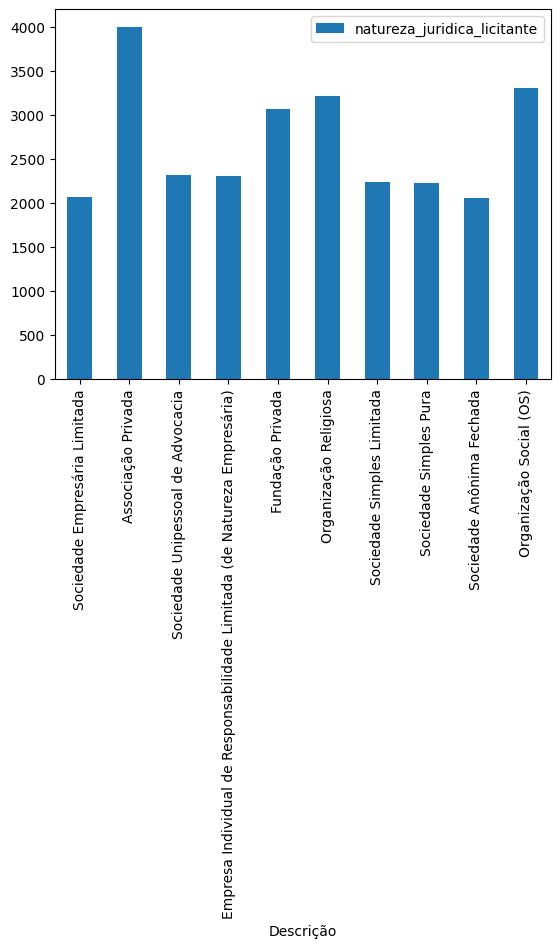

In [231]:
df_natureza_juridica.plot(kind='bar', x='Descrição', y='natureza_juridica_licitante')

A Classificação Nacional de Atividade Econômica (CNAE) padroniza as atividades econômicas das pessoas físicas e jurídicas do país. A tabela de códigos e denominações da CNAE foi oficializada mediante publicação no DOU - Resoluções IBGE/CONCLA nº 01 de 04 de setembro de 2006 e nº 02, de 15 de dezembro de 2006.

In [232]:
len(df['cnae_principal_licitante'].unique())

470

In [233]:
# A coluna divisao mostra o intervalo do grupo de cnae no formato inicio .. fim
# Vamos criar uma coluna divisao_slice que será um objeto slice para facilitar a busca
# de grupos de cnae a partir da string divisao

def get_slice_cnae(x):
    n1, n2 = x.split(' .. ')
    return slice(int(n1)-1, int(n2))

df_cnae = pd.read_csv('divisoes_cnae.csv', on_bad_lines='skip', sep='\t')
df_cnae.columns = ['secao', 'divisao', 'grupo']
df_cnae['divisao_slice'] = df_cnae['divisao'].apply(lambda x: get_slice_cnae(x))

In [234]:
# A lista grupos_cnae é povoada com a descrição de cada grupo
# de cnae a partir do índice da divisão e depois criamos uma coluna
# no dataframe original com a descrição do grupo de cnae

grupos_cnae = [''] * 99
for i, row in df_cnae.iterrows():
    tamanho_secao = row['divisao_slice'].stop - row['divisao_slice'].start
    grupos_cnae[row['divisao_slice']] = [row['grupo']] * tamanho_secao


# O valor 04 é utilizado pois não há grupo de cnae para os valores nulos
# e nem para os valores que começam com 04
df['cnae_principal_licitante'].fillna('04', inplace=True)
df['grupo_cnae'] = df['cnae_principal_licitante'].apply(lambda x: grupos_cnae[int(str(x)[:2])-1] if x != '04' else 'ND')

/tmp/ipykernel_117703/1921604586.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cnae_principal_licitante'].fillna('04', inplace=True)
/tmp/ipykernel_117703/1921604586.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '04' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['cnae_principal_licitante'].fillna('04', inplace=True)


<Axes: xlabel='grupo_cnae'>

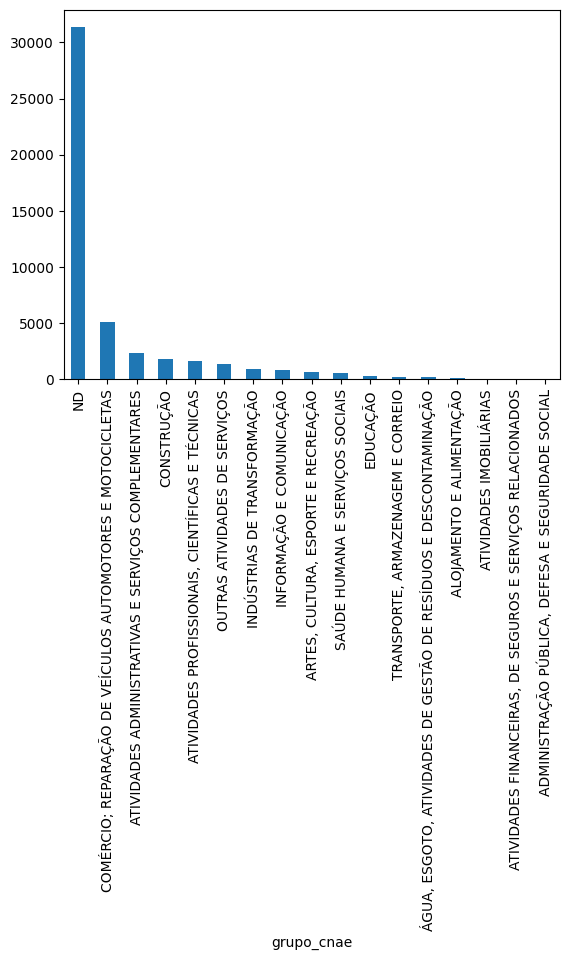

In [235]:
df['grupo_cnae'].value_counts().plot(kind='bar')

A variável `'tempo_abertura_publicacao_licitacao'` mostra a quantidade de dias decorrida entre a abertura da empresa e a publicação da licitação. Vê-se que a maioria das empresas está em uma faixa de até 3.000 dias (ou 8 anos). Há alguns exemplos negativos, indicando empresas que supostamente foram abertas após a licitação. Tal situação pode significar erro nos dados ou fraude no procedimento licitatório.

<Axes: ylabel='Frequency'>

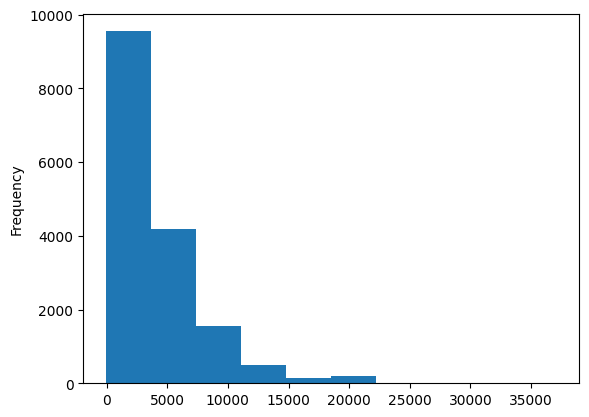

In [236]:
df['tempo_abertura_publicacao_licitacao'].plot(kind='hist')

In [237]:
df['tempo_abertura_publicacao_licitacao'][df['tempo_abertura_publicacao_licitacao'] < 0]

1154    -54.000
16846   -23.000
18370   -34.000
19975   -62.000
20311    -5.000
22257   -43.000
40741   -69.000
41832    -9.000
Name: tempo_abertura_publicacao_licitacao, dtype: float64

In [238]:
df['tempo_abertura_publicacao_licitacao'].sort_values(ascending=False)[:5]

35043   37101.000
32423   37037.000
8070    36347.000
45756   21160.000
29101   20784.000
Name: tempo_abertura_publicacao_licitacao, dtype: float64

#### 3. Transformação dos dados

In [239]:
df.columns

Index(['esfera', 'natureza_orgao', 'modalidade_licitacao',
       'classificacao_objeto', 'ano', 'data_publicacao', 'semana_publicacao',
       'semanas_pagamentos', 'total_orcado', 'total_pago',
       'total_pagamentos_licitante', 'max_pagamento_licitante',
       'quantidade_licitacoes_licitante', 'qtd_cnaes_licitante',
       'cnae_principal_licitante', 'data_inicio_licitante',
       'situacao_cadastral_licitante', 'quantidade_socios_licitante',
       'capital_social_licitante', 'porte_empresa_licitante',
       'natureza_juridica_licitante', 'socios_licitante',
       'tempo_abertura_publicacao_licitacao', 'ano_eleicao', 'grupo_cnae'],
      dtype='object')

In [240]:
df['natureza_orgao'].unique()

array(['ADMINISTRAÇÃO DIRETA MUNICIPAL', 'ADMINISTRAÇÃO DIRETA ESTADUAL',
       'ADMINISTRAÇÃO INDIRETA ESTADUAL',
       'PODER EXECUTIVO MUNICIPAL > 50.000 HAB',
       'PODER EXECUTIVO MUNICIPAL < 50.000 HAB', 'PODER LEGISLATIVO/ TCE',
       'PODER LEGISLATIVO MUNICIPAL > 50.000 HAB',
       'PODER LEGISLATIVO MUNICIPAL< 50.000 HAB',
       'ADMINISTRAÇÃO INDIRETA MUNICIPAL E FUNDOS ESPECIAIS VINC. AOS MUNICÍPIOS',
       'PODER JUDICIÁRIO', 'MINISTÉRIO PÚBLICO ', 'DEFENSORIA PÚBLICA',
       'CONSÓRCIO PÚBLICO'], dtype=object)

In [241]:
df['natureza_orgao'] = df['natureza_orgao'].apply(lambda x: x.replace('<',' menor').replace('>',' maior'))
df['natureza_orgao'] = df['natureza_orgao'].apply(lambda x: slugify(x))
df['natureza_orgao'].unique()

array(['administracao-direta-municipal', 'administracao-direta-estadual',
       'administracao-indireta-estadual',
       'poder-executivo-municipal-maior-50-000-hab',
       'poder-executivo-municipal-menor-50-000-hab',
       'poder-legislativo-tce',
       'poder-legislativo-municipal-maior-50-000-hab',
       'poder-legislativo-municipal-menor-50-000-hab',
       'administracao-indireta-municipal-e-fundos-especiais-vinc-aos-municipios',
       'poder-judiciario', 'ministerio-publico', 'defensoria-publica',
       'consorcio-publico'], dtype=object)

In [242]:
df['modalidade_licitacao'].unique()

array(['SRP - RDC', nan, 'CREDENCIAMENTO - CHAMAMENTO PÚBLICO',
       'PREGÃO ELETRÔNICO ', 'CONCORRÊNCIA PRESENCIAL',
       'TOMADA DE PREÇOS', 'SRP - PREGÃO ELETRÔNICO', 'PREGÃO PRESENCIAL',
       'SRP - PREGÃO PRESENCIAL', 'CHAMADA PÚBLICA - OUTROS',
       'SISTEMA DE REGISTRO DE PREÇO', 'PUBLICIDADE - CONCORRÊNCIA',
       'CONVITE', 'CHAMADA PÚBLICA - ALIMENTAÇÃO ESCOLAR',
       'SRP - CONCORRÊNCIA', 'ABERTO', 'PUBLICIDADE - TOMADA DE PREÇOS',
       'FECHADO', 'RDC ELETRÔNICO - ABERTO', 'CONCORRÊNCIA ELETRÔNICA',
       'RDC PRESENCIAL - ABERTO'], dtype=object)

In [243]:
df['modalidade_licitacao'].fillna('ND', inplace=True)
df['modalidade_licitacao'] = df['modalidade_licitacao'].apply(lambda x: slugify(x))
df['modalidade_licitacao'] = df['modalidade_licitacao'].apply(lambda x: 'pregao-eletronico' if x == 'srp-pregao-eletronico' else x)
df['modalidade_licitacao'] = df['modalidade_licitacao'].apply(lambda x: 'pregao-presencial' if x == 'srp-pregao-presencial' else x)
df['modalidade_licitacao'].unique()

/tmp/ipykernel_117703/3608771480.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['modalidade_licitacao'].fillna('ND', inplace=True)


array(['srp-rdc', 'nd', 'credenciamento-chamamento-publico',
       'pregao-eletronico', 'concorrencia-presencial', 'tomada-de-precos',
       'pregao-presencial', 'chamada-publica-outros',
       'sistema-de-registro-de-preco', 'publicidade-concorrencia',
       'convite', 'chamada-publica-alimentacao-escolar',
       'srp-concorrencia', 'aberto', 'publicidade-tomada-de-precos',
       'fechado', 'rdc-eletronico-aberto', 'concorrencia-eletronica',
       'rdc-presencial-aberto'], dtype=object)

In [244]:
df['classificacao_objeto'].unique()

array(['SERVIÇO - OUTROS', 'LOCAÇÃO DE IMÓVEIS', 'OUTRO (ESPECIFICAR)',
       'COMPRA - MATERIAL PERMANENTE', 'COMPRA - MATERIAL DE CONSUMO',
       'OBRA', 'SERVIÇO DE PUBLICIDADE',
       'SERVIÇO DE NATUREZA CONTÍNUA (EXCETO ENGENHARIA)', 'CONCESSÃO',
       'UTILIZAÇÃO DE PROGRAMA DE INFORMÁTICA', 'SERVIÇO DE CONSULTORIA',
       'LOCAÇÃO - OUTROS', 'LOCAÇÃO DE EQUIPAMENTOS',
       'SERVIÇO DE ENGENHARIA', 'CESSÃO DE DIREITOS',
       'AQUISIÇÃO DE BENS IMÓVEIS', 'ALIENAÇÃO DE BENS MÓVEIS',
       'ALIENAÇÃO DE BENS IMÓVEIS',
       'SERVIÇO DE ORGANIZAÇÃO DE CONCURSO PÚBLICO', 'PERMISSÃO'],
      dtype=object)

In [245]:
df['classificacao_objeto'].fillna('ND', inplace=True)
df['classificacao_objeto'] = df['classificacao_objeto'].apply(lambda x: slugify(x))
df['classificacao_objeto'].unique()

/tmp/ipykernel_117703/611043726.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['classificacao_objeto'].fillna('ND', inplace=True)


array(['servico-outros', 'locacao-de-imoveis', 'outro-especificar',
       'compra-material-permanente', 'compra-material-de-consumo', 'obra',
       'servico-de-publicidade',
       'servico-de-natureza-continua-exceto-engenharia', 'concessao',
       'utilizacao-de-programa-de-informatica', 'servico-de-consultoria',
       'locacao-outros', 'locacao-de-equipamentos',
       'servico-de-engenharia', 'cessao-de-direitos',
       'aquisicao-de-bens-imoveis', 'alienacao-de-bens-moveis',
       'alienacao-de-bens-imoveis',
       'servico-de-organizacao-de-concurso-publico', 'permissao'],
      dtype=object)

In [246]:
df['grupo_cnae'].unique()

array(['OUTRAS ATIVIDADES DE SERVIÇOS', 'ND',
       'SAÚDE HUMANA E SERVIÇOS SOCIAIS',
       'COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E MOTOCICLETAS',
       'ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEMENTARES',
       'ATIVIDADES PROFISSIONAIS, CIENTÍFICAS E TÉCNICAS', 'CONSTRUÇÃO',
       'INFORMAÇÃO E COMUNICAÇÃO', 'INDÚSTRIAS DE TRANSFORMAÇÃO',
       'EDUCAÇÃO', 'TRANSPORTE, ARMAZENAGEM E CORREIO',
       'ARTES, CULTURA, ESPORTE E RECREAÇÃO',
       'ÁGUA, ESGOTO, ATIVIDADES DE GESTÃO DE RESÍDUOS E DESCONTAMINAÇÃO',
       'ALOJAMENTO E ALIMENTAÇÃO', 'ATIVIDADES IMOBILIÁRIAS',
       'ADMINISTRAÇÃO PÚBLICA, DEFESA E SEGURIDADE SOCIAL',
       'ATIVIDADES FINANCEIRAS, DE SEGUROS E SERVIÇOS RELACIONADOS'],
      dtype=object)

In [247]:
df['grupo_cnae'].fillna('ND', inplace=True)
df['grupo_cnae'] = df['grupo_cnae'].apply(lambda x: slugify(x))
df['grupo_cnae'].unique()

/tmp/ipykernel_117703/1404773545.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['grupo_cnae'].fillna('ND', inplace=True)


array(['outras-atividades-de-servicos', 'nd',
       'saude-humana-e-servicos-sociais',
       'comercio-reparacao-de-veiculos-automotores-e-motocicletas',
       'atividades-administrativas-e-servicos-complementares',
       'atividades-profissionais-cientificas-e-tecnicas', 'construcao',
       'informacao-e-comunicacao', 'industrias-de-transformacao',
       'educacao', 'transporte-armazenagem-e-correio',
       'artes-cultura-esporte-e-recreacao',
       'agua-esgoto-atividades-de-gestao-de-residuos-e-descontaminacao',
       'alojamento-e-alimentacao', 'atividades-imobiliarias',
       'administracao-publica-defesa-e-seguridade-social',
       'atividades-financeiras-de-seguros-e-servicos-relacionados'],
      dtype=object)

#### 4. Normalização dos dados

In [301]:
continuas = ['total_orcado', 'total_pago', 'total_pagamentos_licitante', \
             'quantidade_licitacoes_licitante', 'max_pagamento_licitante',\
              'semana_publicacao', 'semanas_pagamentos', 'quantidade_socios_licitante',\
                     'capital_social_licitante', 'tempo_abertura_publicacao_licitacao', \
                            'qtd_cnaes_licitante', 'ano', 'ano_eleicao']
categoricas = ['natureza_orgao', 'modalidade_licitacao',
       'classificacao_objeto', 'grupo_cnae']
ordinais = ['situacao_cadastral_licitante', 'porte_empresa_licitante']

In [302]:
len(continuas) + len(categoricas) + len(ordinais)

19

In [303]:
df_normalizado = df[continuas + categoricas + ordinais].copy()

In [304]:
df_normalizado.fillna(0, inplace=True)

In [306]:
for c in continuas:
    scaler = MinMaxScaler()
    df_normalizado[c] = scaler.fit_transform(df[[c]])

In [307]:
for c in categoricas:
    encoder = OneHotEncoder()
    df_encoded = pd.DataFrame(encoder.fit_transform(df[[c]]).toarray(), columns=encoder.get_feature_names_out())
    df_normalizado = pd.concat([df_normalizado, df_encoded], axis=1).drop(columns=[c])

In [308]:
df_normalizado.shape

(47464, 84)

In [309]:
df_normalizado.fillna(0, inplace=True)

In [310]:
df_normalizado.head()

,total_orcado,total_pago,total_pagamentos_licitante,quantidade_licitacoes_licitante,max_pagamento_licitante,semana_publicacao,semanas_pagamentos,quantidade_socios_licitante,capital_social_licitante,tempo_abertura_publicacao_licitacao,...,grupo_cnae_atividades-profissionais-cientificas-e-tecnicas,grupo_cnae_comercio-reparacao-de-veiculos-automotores-e-motocicletas,grupo_cnae_construcao,grupo_cnae_educacao,grupo_cnae_industrias-de-transformacao,grupo_cnae_informacao-e-comunicacao,grupo_cnae_nd,grupo_cnae_outras-atividades-de-servicos,grupo_cnae_saude-humana-e-servicos-sociais,grupo_cnae_transporte-armazenagem-e-correio
0,0.000,0.000,0.000,0.007,0.000,0.706,0.358,0.000,0.000,0.522,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.196,0.634,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
2,0.000,0.002,0.002,0.000,0.000,0.824,0.780,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.216,0.230,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.022,0.000,0.078,0.161,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000


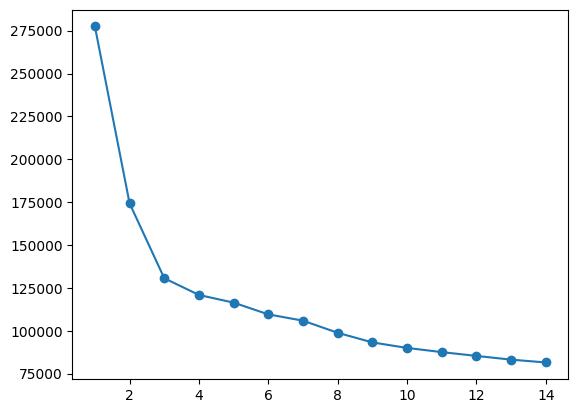

In [311]:
# importando algoritmo k-means
from sklearn.cluster import KMeans
%matplotlib inline

# quantidade de grupos que vamos realizar os testes
ks = range(1, 15)
# armazena o valor do índice para cada partição gerada
inertias = []
for k in ks:
  # executa o k-means para aquela quantidade de grupos
  km = KMeans(n_clusters=k, random_state=8, n_init='auto')
  # aplica a configuração do agrupamento gerado aos dados para obter o índice
  km.fit(df_normalizado)
  # calcula o erro quadrático médio
  inertias.append(km.inertia_)
# plota o gráfico
plt.plot(ks, inertias, marker='o')

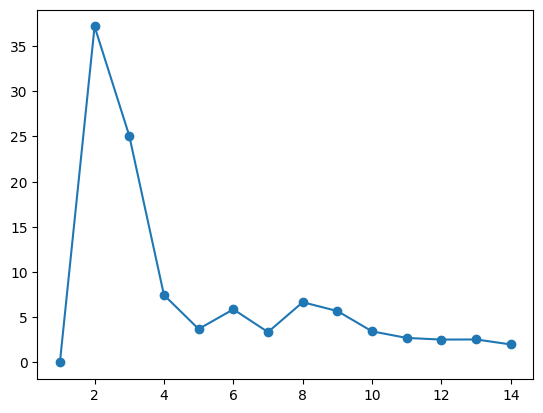

In [312]:
diff = [(1 - (inertias[i] / inertias[i-1]))*100 if i > 0 else 0 for i in range(0,len(inertias))]
plt.plot(range(1,len(diff)+1), diff, marker='o')

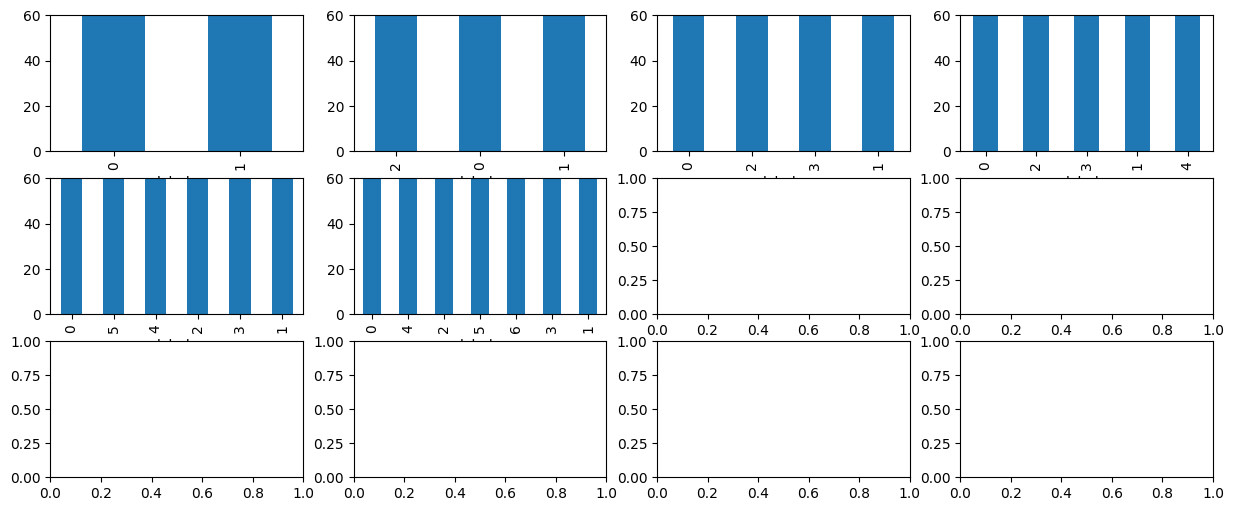

In [314]:
# configuração do gráfico que vai ser gerado
fig, axs = plt.subplots(3,4, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()

# dataframe para armazenar os dados
df = pd.DataFrame()

# intervalo com a quantidade de grupos que vamos dividir os dados
ks = range(2, 8)
for k in ks:
  # executa o kmeans para cada quantidade de grupos
  km = KMeans(n_clusters=k, random_state=8, n_init='auto')
  # relaciona o resultado gerado com os dados da base
  km.fit(df_normalizado)
  # resgata os rótulos (grupos) para cada objeto da base
  labels = km.labels_.tolist()
  # cria um dataframe para facilitar a contagem dos objetos em cada grupo
  df['labels'] = labels
  # plota a quantidade de objetos em cada grupo
  df['labels'].value_counts().plot(kind='bar',ax=axs[k-2],ylim=(0,60))